In [1]:
import os
import gc
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from PIL import Image

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot.inputs.tf_keras import PlotLossesCallback

from sklearn.model_selection import train_test_split

In [2]:
#Kaggle environment

images_path = '../input/plant-pathology-2020-fgvc7/images' 
train_path =  '../input/plant-pathology-2020-fgvc7/train.csv'
test_path =  '../input/plant-pathology-2020-fgvc7/test.csv' 

image_size = 256

train =  pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [57]:
train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [3]:
def load(dataset, path=images_path):
    img_arr = []
    for img_name in dataset:
        img = Image.open(os.path.join(path, img_name + '.jpg'))
        img = img.resize((image_size,image_size))
        img_sequence = np.asarray(img)
        img_arr.append(np.array(img_sequence))
        img.close()
    return img_arr

In [4]:
train_images = np.array(load(train['image_id']))

In [5]:
#Flatten
img_rows, img_cols = image_size, image_size

if K.image_data_format() == 'channels_last':
    X_train = train_images.reshape(train_images.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
else:
    X_train = train_images.reshape(train_images.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)

In [6]:
#Normalize
X_train = X_train.astype('float32')

X_train /= 255

num_classes = 4

y_train = train.copy()
y_train.drop(columns=['image_id'], inplace=True)
gc.collect

<function gc.collect(generation=2)>

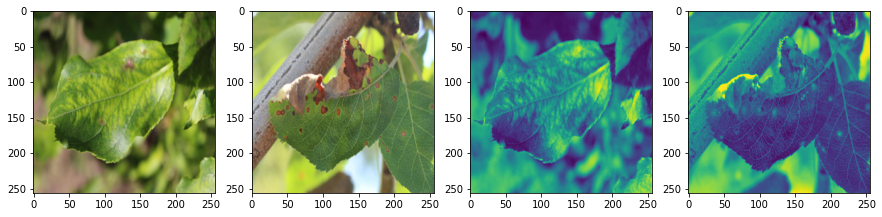

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(2):
        ax[i].imshow(train_images[i])
        ax[i+2].imshow(X_train[i][:, :, 0])

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2000)

In [9]:
def get_cnn3():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
    
        Flatten(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])


model = get_cnn3()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 64)      1

In [10]:
#Augumentation
train_datagen = ImageDataGenerator(rotation_range=30,
                                width_shift_range=0.25,
                                height_shift_range=0.25,
                                shear_range=0.2,
                                zoom_range=0.2, 
                                horizontal_flip=True,
                                vertical_flip=True)
train_datagen.fit(X_train)

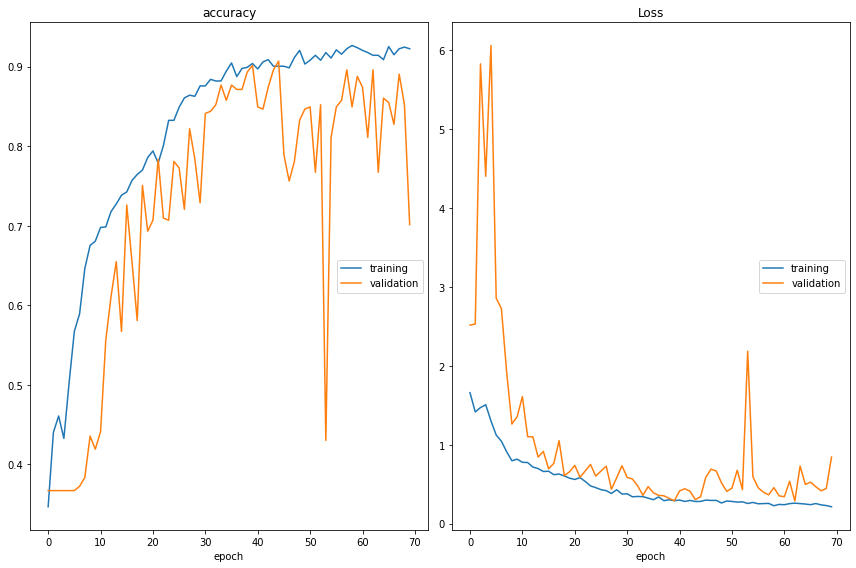

accuracy
	training         	 (min:    0.347, max:    0.927, cur:    0.922)
	validation       	 (min:    0.367, max:    0.907, cur:    0.701)
Loss
	training         	 (min:    0.215, max:    1.661, cur:    0.215)
	validation       	 (min:    0.287, max:    6.063, cur:    0.845)


In [11]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
          epochs=70,
          verbose=1,
          callbacks=[PlotLossesCallback()],
          validation_data=train_datagen.flow(X_val, y_val, batch_size=16))

In [13]:
model.save('model_1', save_format='h5')

In [52]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

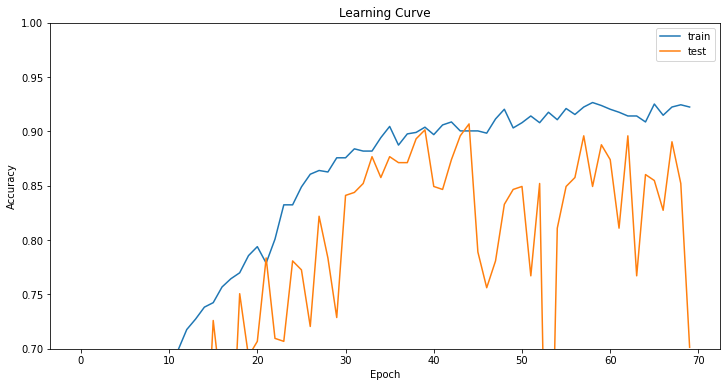

In [53]:
draw_learning_curve(history, 'accuracy', ylim=(0.7, 1.))

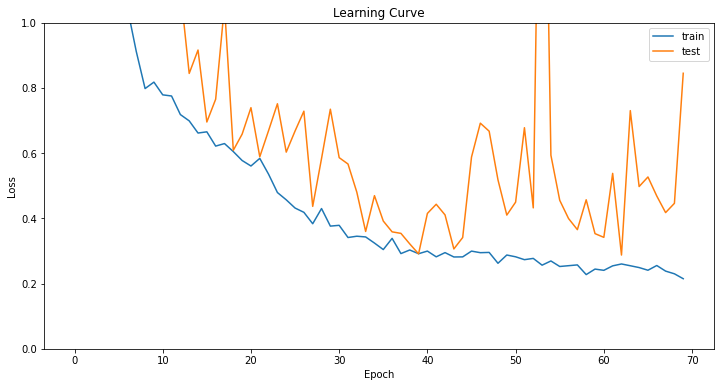

In [54]:
draw_learning_curve(history, 'loss', ylim=(0., 1.))

In [55]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.7884156107902527
Test accuracy: 0.7315068244934082
CNN Error: 26.85%


In [24]:
y_pred = model.predict(X_val)

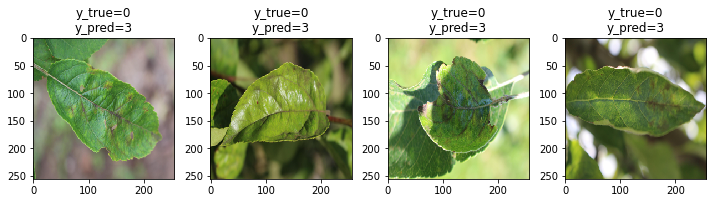

In [50]:
def get_diff(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), np.argmax(b)

limit = 15
cur_limit = 0
fig = plt.figure(figsize=(10, 10))
X_test_plot = X_val.reshape( X_val.shape )

for it, (idx, y_test_val, y_pred_val) in enumerate(get_diff(y_val, y_pred)):
    if cur_limit > limit: break
      
    plt.subplot(4,4,it+1)
    plt.imshow(X_test_plot[idx], interpolation='none')
    plt.title('y_true={0}\ny_pred={1}'.format(y_test_val, y_pred_val))
    plt.tight_layout()
        
    cur_limit += 1

In [56]:
#Kaggle test

In [14]:
test_images = np.array(load(test['image_id']))

if K.image_data_format() == 'channels_last':
    X_test = test_images.reshape(test_images.shape[0], img_rows, img_cols, 3)
else:
    X_test = test_images.reshape(test_images.shape[0], 3, img_rows, img_cols)
  
X_test = X_test.astype('float32')

X_test /= 255

In [15]:
predict = model.predict(X_test)

In [22]:
healthy = []
multiple_diseases = []
rust = []
scab = []
for i in predict:
    healthy.append(i[0])
    multiple_diseases.append(i[1])
    rust.append(i[2])
    scab.append(i[3])
    
test['healthy'] = healthy
test['multiple_diseases'] = multiple_diseases
test['rust'] = rust
test['scab'] = scab

In [23]:
test.head(3)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.003453,0.016562,0.979849,0.000137
1,Test_1,0.014435,0.024210,0.961063,0.000292
2,Test_2,0.468047,0.068169,0.000745,0.463038


In [21]:
test.to_csv('submission.csv',index = False)
#Kaggle private score 0.90337